# 1. Import and Install Dependencies

In [1]:
!pip install tensorflow==2.8.2 tensorflow-gpu==2.8.2 opencv-python mediapipe sklearn matplotlib

     -------------------------------------- 438.3/438.3 MB 2.4 MB/s eta 0:00:00
     -------------------------------------- 438.3/438.3 MB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 5.8/5.8 MB 4.8 MB/s eta 0:00:00
     -------------------------------------- 462.3/462.3 kB 4.8 MB/s eta 0:00:00
     ---------------------------------------- 1.4/1.4 MB 4.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: tensorflow-gpu
    Found existing installation: tens

In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [3]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [8]:
draw_styled_landmarks(frame, results)

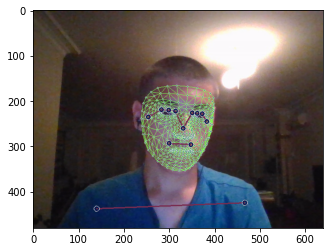

In [9]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [10]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# 4. Setup Folders for Collection

In [11]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [12]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [160]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [158]:
# Run this if you want to quit collecting data before it's over
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [14]:
label_map = {label:num for num, label in enumerate(actions)}

In [15]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [16]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [17]:
np.array(sequences).shape

(90, 30, 1662)

In [18]:
np.array(labels).shape

(90,)

In [19]:
X = np.array(sequences)

In [20]:
X.shape

(90, 30, 1662)

In [21]:
y = to_categorical(labels).astype(int)

In [22]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [24]:
y_test.shape

(5, 3)

# 7. Build and Train LSTM Neural Network

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [26]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [27]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [28]:
res = [.7, 0.2, 0.1]

In [29]:
actions[np.argmax(res)]

'hello'

In [30]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [31]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 [==============================] - 2s 45ms/step - loss: 1.8551 - categorical_accuracy: 0.2824
Epoch 2/2000
3/3 [==============================] - 0s 50ms/step - loss: 1.1401 - categorical_accuracy: 0.2353
Epoch 3/2000
3/3 [==============================] - 0s 43ms/step - loss: 1.6521 - categorical_accuracy: 0.3882
Epoch 4/2000
3/3 [==============================] - 0s 43ms/step - loss: 2.9829 - categorical_accuracy: 0.3059
Epoch 5/2000
3/3 [==============================] - 0s 44ms/step - loss: 11.2094 - categorical_accuracy: 0.3647
Epoch 6/2000
3/3 [==============================] - 0s 45ms/step - loss: 4.3130 - categorical_accuracy: 0.2941
Epoch 7/2000
3/3 [==============================] - 0s 49ms/step - loss: 2.3210 - categorical_accuracy: 0.3294
Epoch 8/2000
3/3 [==============================] - 0s 44ms/step - loss: 1.4566 - categorical_accuracy: 0.3412
Epoch 9/2000
3/3 [==============================] - 0s 49ms/step - loss: 1.1685 - categorical_accuracy: 0.4118


3/3 [==============================] - 0s 41ms/step - loss: 1.3303 - categorical_accuracy: 0.7882
Epoch 75/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.9815 - categorical_accuracy: 0.6471
Epoch 76/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.4721 - categorical_accuracy: 0.7647
Epoch 77/2000
3/3 [==============================] - 0s 42ms/step - loss: 0.3582 - categorical_accuracy: 0.9176
Epoch 78/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.3280 - categorical_accuracy: 0.8706
Epoch 79/2000
3/3 [==============================] - 0s 43ms/step - loss: 0.1511 - categorical_accuracy: 0.9647
Epoch 80/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.1102 - categorical_accuracy: 0.9882
Epoch 81/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.0797 - categorical_accuracy: 0.9529
Epoch 82/2000
3/3 [==============================] - 0s 44ms/step - loss: 1.8388 - categorical_accuracy: 0.6353
Epoch 

3/3 [==============================] - 0s 44ms/step - loss: 0.9032 - categorical_accuracy: 0.4118
Epoch 147/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.8491 - categorical_accuracy: 0.6471
Epoch 148/2000
3/3 [==============================] - 0s 42ms/step - loss: 0.8822 - categorical_accuracy: 0.6588
Epoch 149/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.8022 - categorical_accuracy: 0.6471
Epoch 150/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.6822 - categorical_accuracy: 0.6353
Epoch 151/2000
3/3 [==============================] - 0s 41ms/step - loss: 2.1042 - categorical_accuracy: 0.3176
Epoch 152/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.0708 - categorical_accuracy: 0.3294
Epoch 153/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.0099 - categorical_accuracy: 0.4235
Epoch 154/2000
3/3 [==============================] - 0s 42ms/step - loss: 1.0590 - categorical_accuracy: 0.658

3/3 [==============================] - 0s 41ms/step - loss: 0.5880 - categorical_accuracy: 0.6941
Epoch 219/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.5516 - categorical_accuracy: 0.7412
Epoch 220/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.3958 - categorical_accuracy: 0.9294
Epoch 221/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.4688 - categorical_accuracy: 0.8941
Epoch 222/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.4301 - categorical_accuracy: 0.9294
Epoch 223/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.3790 - categorical_accuracy: 0.9412
Epoch 224/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.3328 - categorical_accuracy: 0.9529
Epoch 225/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.2952 - categorical_accuracy: 0.9647
Epoch 226/2000
3/3 [==============================] - 0s 42ms/step - loss: 0.3257 - categorical_accuracy: 0.882

KeyboardInterrupt: 

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-trai

# 8. Make Predictions

In [33]:
res = model.predict(X_test)

In [34]:
actions[np.argmax(res[4])]

'thanks'

In [35]:
actions[np.argmax(y_test[4])]

'thanks'

# 9. Save Weights

In [36]:
model.save('action.h5')

In [37]:
model.load_weights('action.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [38]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [39]:
yhat = model.predict(X_test)

In [40]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [41]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[3, 0],
        [1, 1]],

       [[3, 0],
        [0, 2]],

       [[3, 1],
        [0, 1]]], dtype=int64)

In [42]:
accuracy_score(ytrue, yhat)

0.8

# 11. Test in Real Time

In [47]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [48]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

TypeError: only size-1 arrays can be converted to Python scalars

<Figure size 1296x1296 with 0 Axes>

In [19]:
sequence.reverse()

In [23]:
len(sequence)

1

In [51]:
sequence.append('def')

In [34]:
sequence.reverse()

In [ ]:
sequence[-30:]

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [20]:
cap.release()
cv2.destroyAllWindows()

In [247]:
res[np.argmax(res)] > threshold

True

In [ ]:
(num_sequences,30,1662)

In [240]:
model.predict(np.expand_dims(X_test[0], axis=0))

array([[5.532469e-04, 9.974770e-01, 1.969744e-03]], dtype=float32)